# Práctica 4
## Alex Bujosa 1098913

**IDS330L, Feb-Abr 2023**

Incorporar Redes Neuronales Convolucionales a la clasificación de Imágenes con Tensorflow

En esta ocasión veremos un poco sobre cómo funcionan, cómo se implementan y cómo podemos usar redes neuronales que integran capas convolucionales para un caso de Clasificación. EL orden que seguiremos es:

1. Ver cómo funcionan las capas convolucionales
2. Crear un modelo de red con Keras y Tensorflow
3. Entrenar modelos
4. Probar la red
5. Jugar con la red

Las preguntas del ejercicio están distribuidas a lo largo del cuaderno. Están enumeradas en **negrita** del 1 al 8.

Para garantizar la validez de su trabajo, guarde sus resultados en un PDF y cárguelo al aula virtual **además** del cuaderno.


# Preparación

In [1]:
from tensorflow.keras.datasets import fashion_mnist
import tensorflow.keras as keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense, Conv2D, Input, MaxPooling2D, Flatten
import numpy as np
np.random.seed(20)

En una capa convolucional, lo que antes hemos definido como una neurona que funciona como un producto punto ahora se implementa de forma similar a una convolución bi-dimensional (un filtro) que consume (o procesa) una porción de la imagen a la vez. La neurona aplica el filtrado a diferentes porciones de la imagen, generando así una interpretación que guarda información por separado sobre las diferentes porciones de la imagen por las que pasa. Si la imagen tiene profundidad (capas), como es el caso de las tres capas de una imagen RGB, los filtros incorporan estas capas en sus cálculos.

Para cada "porción" de la imagen, iniciando en una posición $(i,j)$, se lleva a cabo una combinación lineal de los datos con la que se alimenta una función de activación, funcionando de forma similar al producto punto que vimos en en perceptrón de la red neuronal conectada. En este caso, si se tienen capas (profundidad), la información de las capas también incluye en el procesamiento. Específicamente, para un porción de una imagen, en una posición $(i,j)$, cada filtro computa

$$ z_{i,j} = \sigma \left( b + \large\sum_{l=0}^{k_H-1} \large\sum_{m=0}^{k_W-1} \large\sum_{n=0}^{D-1} w_{l,m,n} \cdot x_{i+l,j+m,n} \right)$$

Donde $\sigma$ es la función de activación, $(k_H \times k_W \times D)$ son las dimensiones del filtro (ancho, alto, profundidad/capas), $w$ las ganancias, y $b$ el sesgo de cada filtro. 

Una de las dimensiones del $w$ surge de la cantidad de capas, $D$, en los datos, así que el tamaño del filtro se define realmente por $k_W$ y $k_H$, y la profundidad dependerá de las capas. Generalmente, aunque no es regla, se definen los filtros de forma cuadrada $k \times k$, para facilitar algunos detalles. La matriz de dimensiones $k \times k$ (que tiene $k^2$ coeficientes) representa el **núcleo** (_kernel_, en inglés) del filtro, que tendrá $Dk^2$ coeficientes y un ($1$) parámetro de sesgo (inglés, _bias_).


En una capa convolucional de una red neuronal, se aplican $N$ filtros, cada uno con $Dk^2 + 1$ parámetros, para procesar la entrada (la imagen). Haciendo esto que tengamos que trabajar con $N \times (Dk^2 +1 )$ parámetros por cada capa convolucional. En un sistema con capacidad de aprendizaje, esto permite reducir grandemente la cantidad de parámetros que entrenar.

Abajo tenemos un método que genera una capa convolutiva de 2 dimensiones para procesar una entrada con `nb_filters` filtros de núcleo $3 \times 3$. Nótese que se especifica nó usar un sesgo (`use_bias=False`), reduciendo aún más los parámetros. Similarmente, se puede notar que usa una función de activación tipor $ReLU$. Con este método podremos facilitar la creación de capas en nuestro modelo.

In [2]:
def conv3x3(input_x,nb_filters):
 """
 Wrapper around convolution layer
 Inputs:
 input_x: input layer / tensor
 nb_filter: Number of filters for convolution
 """
 return Conv2D(nb_filters, kernel_size=(3,3), use_bias=False,
 activation='relu', padding="same")(input_x)

En un sistema inteligente, su capacidad de aprendizaje surge de poder ajustar los parámetros en los filtros de acuerdo a la experiencia. Esto hace que cada filtro pueda ajustarse a "reconocer" algo en particular de la entrada. Por ejemplo, si $N=32$, se pueden reconocer 32 características distinas en una imagen, como líneas en una orientación específica, una variación de color, etc. Vale notar que estas son características de bajo nivel (al nivel de pixeles) en la imagen. Si existieran más capas convolucionales encima de esta, se pudieran reconocer rasgos más concretos como formas de cara, o el contorno de un objeto, en base a combinaciones de las 32 características de la primera capa. Esto se ilustra en la Figura 3-1 del libro (pg. 76), que muestra cómo cada capa convolucional resume **toda** la entrada, en términos de la cantidad de neurnas que tenga.

Cada filtro se aplica a una porción $k \times k$ de la imagen a la vez, empezando en el punto $(i,j)$ y produciendo un valor $z_{i,j}$, y avanzando hasta completar la imagen. Según las necesidades, se puede definir qué tan "rápido" avanza el filtro por la imagen, tanto a lo largo como lo ancho. Por ejemplo, cada 1 pixel, o cada 2, etc.; que generalmente se aplica igual para ambas direcciones (horizonal o vertical). Esto implica que mientras más grande el "paso" (inglés, _stride_), menos datos se producen como resultado. Por tanto, el tamaño del núcleo y los pasos que toma influyen en la cantidad de datos finales. Esto se ilustra en la Figura 3-2 del libro (pg. 78), donde se observa también que la imagen se **rellena** con ceros (inglés, _padding_) para permitir que el filtro pueda dar todos los pasos que necesita.

Si la cantidad de pasos que puede dar un filtro por la imagen en cada dirección se representa por $H_o \times W_o $, tomando que los $N$ filtros se aplican a toda la imagen, podemos conlucir que cada capa convolucional produce $H_o \times W_o \times N$ datos, que resumen la interpretación de cada filtro (o neurona) de la entrada.

# Aplicación

Para crear una red neuronal convolucional (inglés, CNN), se debe aplicar cierto criterio sobre cómo se transforma la información a medida que pasa por sus diferentes capas. Existen diferentes arquitecturas para diferentes fines. En nuestro caso, vamos a probar una arquitectura que permita realizar clasificación de objetos en imágenes. Para esto pudiera no funcionarnos la Red Neuronal Conectada (densas) que usamos antes, ya que necesitamos utilizar características espaciales relacionadas con la forma de los elementos. 

Para formar una CNN con imágenes, muchas veces se combinan capas convolucionales para extraer características de las imágenes, con capas densas que ayudan a clasificar las imágenes (clasificando igual que en los ejercicios anteriores). Sin embargo, a veces es necesario manipular la cantidad de información entre capas. 

Uno de los métodos para manipular la cantidad de información entre capas es insertar entre ellas una capa de _pooling_, que usa filtros **no entrenables** que se usan para resumir los valores en su entrada tomando lo que "ven" por una ventana y extrayendo algún resumen de los datos. Por ejemplo, una capa de _pooling_ que extraiga el valor máximo de una ventana $2\times 2$ ($k=2$), que se avance cada 2 valores en cada dirección ($s=2$), terminaría reduciendo el ancho y largo de los datos a la mitad (diviendo entre 2). Lo importante de esto es que se reducen la cantidad de computaciones en las próximas capas. En el caso de ejemplo, se reduce por $2\times 2=4$ la cantidad de datos con los que debe trabajar la próxima capa.

Como las capas convolucionales y de _pooling_ alteran la cantidad de información, se debe tomar en cuenta cómo evoluciona la cantidad de información entre cada capa. Es por esto que se estudian las arquitecturas de las CNN al tratar de implementarlas para una aplicación específica.

# Ejercicio

Estaremos aplicando una CNN para clasificar las imágenes del dataset [Fashion-MNIST](https://www.tensorflow.org/datasets/catalog/fashion_mnist), que tienen propiedades similares al dataset de números de MNIST que usamos para los ejercicios anteriores (por ej.: las imágenes son $28\times 28$ pixeles). Estas, sin embargo, contienen formas de prendas de vestir, también clasificadas en 10 categorías, por lo que aprovecharemos la capacidad de las CNN para procesar información espacial para poder identificar diferentes rasgos en una misma imágen para tener un mejor resultado de estimación.

In [3]:
# setup parameters
num_classes = 10 # target number of classes
img_h, img_w = 28, 28 # input dimensions

Tal como habíamos hecho antes, prepararemos el conjunto de datos para tener la forma requerida por nuestra red, en este caso $(28 \times 28 \times 1)$, y a normalizar los datos entre 0 y 1.

In [4]:
def get_dataset():
    """
    Return processed and reshaped dataset for training
    In this cases Fashion-mnist dataset.
    """
    # load mnist dataset
    (x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
    # test and train datasets
    print("Nb Train:", x_train.shape[0], "Nb test:",x_test.shape[0])
    x_train = x_train.reshape(x_train.shape[0], img_h, img_w, 1)
    x_test = x_test.reshape(x_test.shape[0], img_h, img_w, 1)
    in_shape = (img_h, img_w, 1)
    # normalize inputs
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    x_train /= 255.0
    x_test /= 255.0
    # convert to one hot vectors
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_test = keras.utils.to_categorical(y_test, num_classes)
    return x_train, x_test, y_train, y_test

x_train, x_test, y_train, y_test = get_dataset()

4422102/4422102 [==============================] - 7s 2us/step
Nb Train: 60000 Nb test: 10000



# La red

Abajo podemos ver cómo se crea el modelo de nuestra CNN, que combina capas convolucionales y de _pooling_ para procesar las imágenes, y usa dos capas densas al final para clasificar las imágenes en una cantidad de categorías específicas.

In [5]:
def create_model(img_h=28, img_w=28, num_classes=10):
 """
 Creates a CNN model for training.
 Inputs:
 img_h: input image height
 img_w: input image width
 Returns:
 Model structure
 """
 inputs = Input(shape=(img_h, img_w, 1))
 x = conv3x3(inputs, 32)
 x = conv3x3(x, 32)
 x = MaxPooling2D(pool_size=(2,2))(x)
 x = conv3x3(x, 64)
 x = conv3x3(x, 64)
 x = MaxPooling2D(pool_size=(2,2))(x)
 x = conv3x3(x, 128)
 x = MaxPooling2D(pool_size=(2,2))(x)
 x = Flatten()(x)
 x = Dense(128, activation="relu")(x)
 preds = Dense(num_classes, activation='softmax')(x)
 model = Model(inputs=inputs, outputs=preds)
 print(model.summary())
 return model


En este caso, el método `create_model` hace el trabajo por nosotros, pero otra forma de crear una estructura similar es usando la clase Sequential de Keras, en algo como :

```python
model = Sequential() # `Sequential` inherits from tf.keras.Model
# 1st block:
model.add(Conv2D(6, kernel_size=(5, 5), padding='same', activation='relu', input_shape=(img_h, img_w, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
# 2nd block:
model.add(Conv2D(16, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
# Dense layers:
model.add(Flatten())
model.add(Dense(120, activation='relu'))
model.add(Dense(84, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))
```

Al crear el modelo, notemos la cantidad de parámetros a entrenar en cada capa (columna "Param #") y la forma de la salida.

In [6]:
# Creamos el modelo de la red
model = create_model(img_h, img_w, num_classes)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        288       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        9216      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        18432     
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 64)        36864     
                                                             

Para crear la red, necesitamos compilar el modelo indicandole los métodos de cálculo de perdida y de optimización que usará para el entrenamiento.

In [7]:
# setup optimizer, loss function and metrics for model
model.compile(loss=keras.losses.categorical_crossentropy,
    optimizer=keras.optimizers.Adam(),
    metrics=['accuracy'])

## Entrenamiento 

El tamaño del batch puede verse influido por la función de pérdida que hayamos elegido. Por el momento, usaremos 128.

Notemos el reducido número de _epochs_ que estamos usando.

In [8]:
batch_size = 128 # batch size
num_epochs = 10 # training epochs

Keras permite aplicar métodos de _callback_ con los que podemos monitorear el progreso del entrenamiento El siguiente método de callback permite ir guardando el modelo al final de cada epoch, en caso de que queramos interrumpir el entrenamiento.

In [10]:
#This is optional if we would like to save our model after every epoch

# To save model after each epoch of training
callback = ModelCheckpoint('mnist_cnn.h5')

In [11]:
# start training
model.fit(x_train, y_train,
 batch_size=batch_size,
 epochs=num_epochs,
 verbose=1,
 validation_data=(x_test, y_test),
 callbacks=[callback])

Epoch 1/10
469/469 [==============================] - 61s 127ms/step - loss: 0.5248 - accuracy: 0.8096 - val_loss: 0.3515 - val_accuracy: 0.8722
Epoch 2/10
469/469 [==============================] - 58s 124ms/step - loss: 0.3019 - accuracy: 0.8903 - val_loss: 0.2812 - val_accuracy: 0.8980
Epoch 3/10
469/469 [==============================] - 66s 142ms/step - loss: 0.2519 - accuracy: 0.9079 - val_loss: 0.2671 - val_accuracy: 0.9039
Epoch 4/10
469/469 [==============================] - 57s 121ms/step - loss: 0.2155 - accuracy: 0.9218 - val_loss: 0.2346 - val_accuracy: 0.9166
Epoch 5/10
469/469 [==============================] - 63s 133ms/step - loss: 0.1897 - accuracy: 0.9320 - val_loss: 0.2336 - val_accuracy: 0.9202
Epoch 6/10
469/469 [==============================] - 62s 131ms/step - loss: 0.1685 - accuracy: 0.9384 - val_loss: 0.2351 - val_accuracy: 0.9175
Epoch 7/10
469/469 [==============================] - 62s 132ms/step - loss: 0.1487 - accuracy: 0.9461 - val_loss: 0.2369 - val_ac

El modelo permite evaluar los resultados del entrenamiento con el conjunto de datos de prueba, aunque parte del entrenamiento implica validación

In [12]:
# Evaluate and print accuracy
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


Test loss: 0.27450981736183167
Test accuracy: 0.9174000024795532


In [13]:
model2 = create_model()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 32)        288       
                                                                 
 conv2d_6 (Conv2D)           (None, 28, 28, 32)        9216      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 14, 14, 64)        18432     
                                                                 
 conv2d_8 (Conv2D)           (None, 14, 14, 64)        36864     
                                                           

En este ejemplo usamos un método distinto de optimización, el de _stochastic gradient descent_ (descenso gradiente estocástico), que fue el que implementamos en el ejercicio anterior para entrenar el la Red Neuronal Conectada (pg. 40 del libro). En el modelo arriba, usamos el "Adam" (_adaptive moment estimation_), presentando en la página 102 del libro.

El callback en este caso es uno que detiene el proces si la precisión de validación no mejora.

In [14]:
model2.compile(optimizer='sgd', loss=keras.losses.categorical_crossentropy,
 metrics=['accuracy'])
# We also instantiate some Keras callbacks, that is, utility functions 
# automatically called at some points during training to monitor it:
callbacks = [
 # To interrupt the training if `val_loss` stops improving for over 3epochs:
 keras.callbacks.EarlyStopping(patience=3, monitor='val_loss')]


In [15]:
# Finally, we launch the training:

model2.fit(x_train, y_train,
 batch_size=batch_size,
 epochs=num_epochs,
 verbose=1,
 validation_data=(x_test, y_test),
 callbacks=callbacks)

Epoch 1/10
469/469 [==============================] - 61s 130ms/step - loss: 1.4080 - accuracy: 0.5037 - val_loss: 0.7636 - val_accuracy: 0.7345
Epoch 2/10
469/469 [==============================] - 55s 117ms/step - loss: 0.6947 - accuracy: 0.7439 - val_loss: 0.6144 - val_accuracy: 0.7799
Epoch 3/10
469/469 [==============================] - 58s 125ms/step - loss: 0.5720 - accuracy: 0.7934 - val_loss: 0.5828 - val_accuracy: 0.7770
Epoch 4/10
469/469 [==============================] - 54s 116ms/step - loss: 0.4950 - accuracy: 0.8216 - val_loss: 0.5120 - val_accuracy: 0.8178
Epoch 5/10
469/469 [==============================] - 59s 125ms/step - loss: 0.4514 - accuracy: 0.8370 - val_loss: 0.4782 - val_accuracy: 0.8297
Epoch 6/10
469/469 [==============================] - 60s 128ms/step - loss: 0.4244 - accuracy: 0.8462 - val_loss: 0.4814 - val_accuracy: 0.8284
Epoch 7/10
469/469 [==============================] - 57s 121ms/step - loss: 0.4006 - accuracy: 0.8548 - val_loss: 0.4012 - val_ac

In [16]:
# Evaluate and print accuracy
score2 = model2.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score2[0])
print('Test accuracy:', score2[1])


Test loss: 0.3778292238712311
Test accuracy: 0.8651000261306763


**1.** ¿Cómo se comparan la precisión de validación (_accuracy_ reportada) de los dos métodos?


#### Model 2 

Test loss: 0.3778292238712311
Test accuracy: 0.8651000261306763

#### Model 1 

Test loss: 0.27450981736183167
Test accuracy: 0.9174000024795532

Notablemente los mejores resultado se aprecian en el primero sobre el segundo modelo ya que tiene mayo porcentaje de acierto y menos de perdida.

## Probemos nuestra suerte

Esta vez, probemos nuestra suerte usando el modelo para intentar clasificar una imagen fuera del conjunto de entrenamiento. 

Para esto usaremos OpenCV para tomar una imagen de un objeto similar a los del conjunto de entrenamiento y ver si nos funciona.

Primero veamos cómo usar la red para obtener una predicción:

In [17]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


Veamos cómo se ve una de las imágenes del conjunto de prueba:

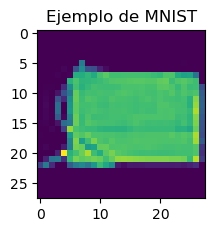

In [18]:
plt.subplot(2, 2, 1)
plt.title("Ejemplo de MNIST")
plt.imshow(x_test[18])

**2.** ¿Cuál es la categoría de esta imagen? Modifique el siguiente bloque para comprobar

Categoría: Bag


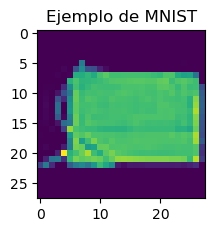

In [20]:
index = 18
plt.subplot(2, 2, 1)
plt.title("Ejemplo de MNIST")
plt.imshow(x_test[index])

class_names = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot"
]

category_number = np.argmax(np.array(y_test[index]))

category  = class_names[category_number]
print("Categoría:", category)

Categoría: Sneaker


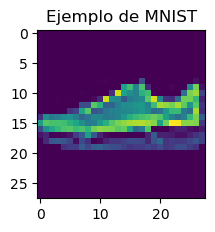

In [21]:
index = 9
plt.subplot(2, 2, 1)
plt.title("Ejemplo de MNIST")
plt.imshow(x_test[index])

class_names = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot"
]

category_number = np.argmax(np.array(y_test[index]))

category  = class_names[category_number]
print("Categoría:", category)

**3.** ¿Cuáles son las categorías del conjunto de datos Fashion MNIST? ¿A cuál pertenece la imagen?

Las categorias son las siguientes

- T-shirt/top
- Trouser
- Pullover
- dress
- coat
- sandal
- shirt
- sneaker
- bag
- Ankle boot


Veamos si el modelo de la CNN predice lo mismo. Primero debemos usar `np.reshape` para preparar la imagen a tener el mismo formato que el que pide la red en su entrada. Luego usamos `predict` para ver lo que dice el modelo:

In [22]:
a = x_test[18].reshape(1,28,28,1)
res = model.predict(a)
cat_a = res.argmax(axis=1)
print("Categoría predicha: {}".format(cat_a))

1/1 [==============================] - 0s 127ms/step
Categoría predicha: [8]


**4.** ¿Por qué es necesario usar `argmax` para obtener la categoría, en vez de solo `res`? Entonces, ¿Qué significa lo que devuelve `predict`? Pista: revise la forma de la salida de la última capa del modelo.

Argmax sirve para encontrar el indico de la psocion con valor maximo en el array de probabilidades 'res' que representa la categoria predicha. Si argmax no se utilizara y simplemente se usara res para obtener la categoria, se obtendría una representación de la probabilidad de la categoría, en lugar de la propia categoría.

El signficado de predict es que toma como entrada una matriz que representa una imagen y devuelve una matriz de salida que representa las probabilidades de pertenencia de esa imagen a cada una de las posibles categorias de salida.

### Probemos ahora una imagen fuera del conjunto.

Empezamos con la imagen "bolso.jpg" disponible junto con este archivo, pasándola por un proceso en el que usamos OpenCV para volverla similar al conjunto de entrenamiento. Esto es, volver la imagen un cuadro 28x28 en escala de grises, normalizado a valores entre 0 y 1. El siguiente método toma una imagen y devuelve la conversión.

In [23]:
def preparar_imagen(img, img_h=28, img_w=28):
    '''Convierte una imagen '''

    res  = cv2.cvtColor(img, cv2.COLOR_RGB2HSV) # Convertir a Hue, Sat, Val
    res[:,:,2] = 255- res[:,:,2] # Invertir Value
    res = cv2.cvtColor(res, cv2.COLOR_HSV2BGR) # Convertir definición del color
    res = cv2.cvtColor(res, cv2.COLOR_BGR2GRAY)  # Convertir a Grises (1-dimensional)
    res = cv2.resize(res, (img_w,img_h), cv2.INTER_AREA) # Cambiar de tamaño
    res = res.reshape(img_h, img_w, 1)
    res = res.astype('float32')
    res /= 255.0
    print(np.shape(res))
    return res

Para obtener la imagen y procesarla:

In [24]:
bolso1 = cv2.imread(r"bolso.jpg")

b1 = preparar_imagen(bolso1)

(28, 28, 1)


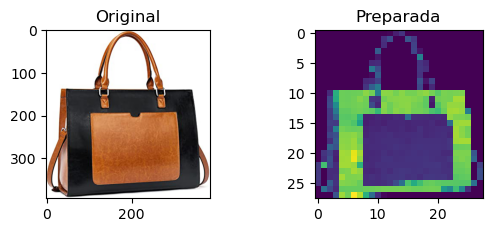

In [25]:
plt.subplot(2, 2, 1)
plt.title("Original")
plt.imshow(cv2.cvtColor(bolso1, cv2.COLOR_RGB2BGR)) # OpenCV importa los colores en formato BGR en vez de RGB, esto intercambia las capas
plt.subplot(2, 2, 2)
plt.title("Preparada")
plt.imshow(b1)

**5.** Utilice las dos redes que entrenamos para predecir la clase de objeto que está en la imagen.

In [26]:
b1 = np.expand_dims(b1, axis=0)
res = model.predict(b1)
model_category_number = res.argmax(axis=1)

model_category_name = class_names[np.argmax(np.array(res))]

print("Modelo 1: Categoría predicha: {}".format(model_category_number))
print("Modelo 1: Nombre de categoría predicha: {}".format(model_category_name))

1/1 [==============================] - 0s 55ms/step
Modelo 1: Categoría predicha: [8]
Modelo 1: Nombre de categoría predicha: Bag


In [32]:
bolso = cv2.imread("bolso.jpg")

b = preparar_imagen(bolso)

b = np.expand_dims(b, axis=0)


res = model2.predict(b)
model2_cat_number = res.argmax(axis=1)

model2_cat_name = class_names[np.argmax(np.array(res))]

print("Modelo 2: Categoría predicha: {}".format(model2_cat_number))
print("Modelo 2: Nombre de categoría predicha: {}".format(model2_cat_name ))

(28, 28, 1)
1/1 [==============================] - 0s 21ms/step
Modelo 2: Categoría predicha: [8]
Modelo 2: Nombre de categoría predicha: Bag


**6.** Intente con las otras imágenes incluidas con este archivo. ¿Qué puede decir de los resultados?

# Shirt

(28, 28, 1)


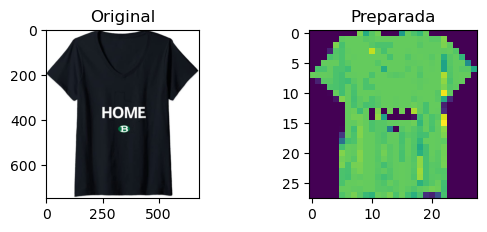

In [33]:
shirt = cv2.imread("shirt.jpg")

shirt_prepared= preparar_imagen(shirt)

plt.subplot(2, 2, 2)
plt.title("Preparada")
plt.imshow(shirt_prepared)

plt.subplot(2, 2, 1)
plt.title("Original")
plt.imshow(cv2.cvtColor(shirt, cv2.COLOR_RGB2BGR)) 

In [34]:
shirt_prepared = np.expand_dims(shirt_prepared, axis=0)
response = model.predict(shirt_prepared)
response2 = model2.predict(shirt_prepared)

model1_category_number = response.argmax(axis=1)
model1_category_number = class_names[np.argmax(np.array(response))]

model2_category_number = response2 .argmax(axis=1)
model2_category_name = class_names[np.argmax(np.array(response2 ))]

print("Modelo 1: Categoría predicha: {}".format(model1_category_number))
print("Modelo 1: Nombre de categoría predicha: {}".format(model1_category_number))

print("Modelo 2: Categoría predicha: {}".format(model2_category_number))
print("Modelo 2: Nombre de categoría predicha: {}".format(model2_category_name))

1/1 [==============================] - 0s 32ms/step
Modelo 1: Categoría predicha: T-shirt/top
Modelo 1: Nombre de categoría predicha: T-shirt/top
Modelo 2: Categoría predicha: [0]
Modelo 2: Nombre de categoría predicha: T-shirt/top


**7.** Intente con dos imágenes  extraídas de Amazon de artículos de las categorías que hemos visto. Las imágenes deberían ser **solo la prenda** y con el fondo blanco. 

(28, 28, 1)


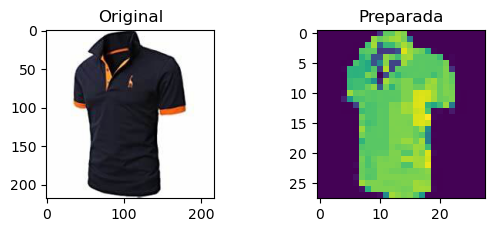

In [37]:
polo = cv2.imread("OIP.jpg")

polo_prepared = preparar_imagen(polo)

plt.subplot(2, 2, 2)
plt.title("Preparada")
plt.imshow(polo_prepared)

plt.subplot(2, 2, 1)
plt.title("Original")
plt.imshow(cv2.cvtColor(polo, cv2.COLOR_RGB2BGR)) 


In [38]:
polo_prepared = np.expand_dims(polo_prepared, axis=0)
response = model.predict(polo_prepared)
response2 = model2.predict(polo_prepared)

model1_category_number = response.argmax(axis=1)
model1_category_name = class_names[np.argmax(np.array(response))]

model2_category_number = response2.argmax(axis=1)
model2_category_name = class_names[np.argmax(np.array(response2))]

print("Modelo 1: Categoría predicha: {}".format(model1_category_number))
print("Modelo 1: Nombre de categoría predicha: {}".format(model1_category_name))

print("Modelo 2: Categoría predicha: {}".format(model2_category_number))
print("Modelo 2: Nombre de categoría predicha: {}".format(model2_category_name))

1/1 [==============================] - 0s 28ms/step
Modelo 1: Categoría predicha: [0]
Modelo 1: Nombre de categoría predicha: T-shirt/top
Modelo 2: Categoría predicha: [6]
Modelo 2: Nombre de categoría predicha: Shirt


# Sneaker

(28, 28, 1)


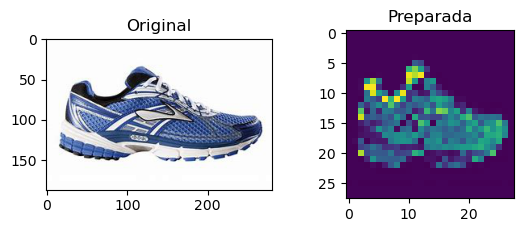

In [39]:
sneaker = cv2.imread("sneaker.jpg")

sneaker_prepared = preparar_imagen(sneaker)

plt.subplot(2, 2, 2)
plt.title("Preparada")
plt.imshow(sneaker_prepared)

plt.subplot(2, 2, 1)
plt.title("Original")
plt.imshow(cv2.cvtColor(sneaker, cv2.COLOR_RGB2BGR)) 

In [40]:
sneaker_prepared = np.expand_dims(sneaker_prepared, axis=0)
response = model.predict(sneaker_prepared)
response2 = model2.predict(sneaker_prepared)

model1_category_number = response.argmax(axis=1)
model1_category_name = class_names[np.argmax(np.array(response))]

model2_category_number = response2.argmax(axis=1)
model2_category_name = class_names[np.argmax(np.array(response2))]

print("Modelo 1: Categoría predicha: {}".format(model1_category_number))
print("Modelo 1: Nombre de categoría predicha: {}".format(model1_category_name))

print("Modelo 2: Categoría predicha: {}".format(model2_category_number))
print("Modelo 2: Nombre de categoría predicha: {}".format(model2_category_name))

1/1 [==============================] - 0s 25ms/step
Modelo 1: Categoría predicha: [8]
Modelo 1: Nombre de categoría predicha: Bag
Modelo 2: Categoría predicha: [8]
Modelo 2: Nombre de categoría predicha: Bag


**8.** Finalmente, ¿hubo algún caso donde no concordaron los dos modelos? ¿Cuál considera estuvo más cerca? ¿Considera que alguna característica del artículo influyó?

En mi caso fue en este ultimo porque me dijo que era un bag, cuando realmente es un sneaker. Al parecer no estuvo tan entrenada la IA para identificar correctamente el objeto evaluado. Ademas de esto pude apreciar que en cuanto al shirt presentado el modelo 1 lo confundio con un t-shirt